In [1]:
import sys
import pdb
import copy
import calendar
import importlib
import numpy as np
import xarray as xr
import cmasher as cmr
import matplotlib as mpl
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.ticker as ticker
from cftime import DatetimeNoLeap as date
from matplotlib.colors import TwoSlopeNorm
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FuncFormatter

plt.rcParams.update({
    'font.size'       : 14,   # Base font size
    'axes.labelsize'  : 13,   # Axis labels
    'xtick.labelsize' : 11,   # X-axis tick labels
    'ytick.labelsize' : 11,   # Y-axis tick labels
    'legend.fontsize' : 12,   # Legend font size
    'figure.titlesize': 16    # Figure title size
})
plt.ioff()

sys.path.insert(1, '/global/homes/j/jhollo/repos/climate_analysis/CLDERA/TEM/limvar_analysis_NERSC')
import plotting_utils as putil
import compute_ensemble_stats as ces
importlib.reload(putil)
importlib.reload(ces)
fix_dtint   = putil.adjust_10daily_integrated_tendency
shift_dtint = putil.shift_integrated_tendency
sig         = putil.filter_significance
cmn         = putil.get_cmap_norm

sys.path.insert(1, '/global/homes/j/jhollo/repos/climate_analysis/CLDERA/wavePaperFigs/util')
import nclcmaps as ncm

In [2]:
importlib.reload(putil)
importlib.reload(ces)

# ----- get counterfatual data
kwargs = {'freq':'monthly', 'return_intersection':False}
u           = putil.get_variable('U', **kwargs)['cfmean']
utendepfd   = putil.get_variable('utendepfd', **kwargs)['cfmean']
utendresvel = putil.get_variable('utendresvel', **kwargs)['cfmean']
utendgw     = putil.get_variable('utendgw', **kwargs)['cfmean']
utenddiff   = putil.get_variable('utenddiff', **kwargs)['cfmean']
epfy        = putil.get_variable('epfy', **kwargs)['cfmean']
epfz        = putil.get_variable('epfz', **kwargs)['cfmean']
psitem      = putil.get_variable('psitem', **kwargs)['cfmean']
psitem_gp   = putil.get_variable('psitem_gradlat', **kwargs)['cfmean']
psitem_glat = putil.get_variable('psitem_gradp', **kwargs)['cfmean']
trop        = putil.get_variable('TROP_P', **kwargs)['cfmean']

# ----- get climatology
allvars = [u, utendepfd, utendresvel, utendgw, utenddiff, epfy, epfz, psitem, psitem_gp, psitem_glat, trop]
climoyears = u.time.dt.year.values
climo = putil.climatology(xr.merge(allvars), 'seasonal')

# ----- get 1991 seasonal means
year1 = putil.seasonal_mean(xr.merge(allvars))
year1 = year1.sel(time=slice(date(1991,6,1), date(1992,5,31)))
year1 = year1.set_xindex('season')

In [3]:
importlib.reload(putil)
importlib.reload(ces)

def make_plot(dvars, epvscale=1e15, rvvscale=40, dslat=1, dsp=1, logepvec=False, logrvvec=True, wspace=0, hspace=0):
    
    # --- plotting settings
    pbuff            = 20           # tropopause buffer if remove_trop_vectors=True
    tlw, tcolor = 4, 'grey'  # tropopause linewidth, color
    cbheight = 0.77          # colorbar height
    # vector field settings
    ulw, ulwz, ucolor = 0.75, 1.33, 'k'
    vw, vhw, vhl      = 0.008,2.4,4   # vector arrow width, head width, and head length to quiver()
    epvcolor            = 'k'          # EP flux vector arrow color
    rvvcolor            = 'royalblue'          # residual velocity vector arrow color
    vecolor           = 'w'          # vector outline color
    vlw               = 0.75         # vector outline linewidth
    
    # variable-dependent settings
    cmap     = {'U':'RdYlBu_r', 'psitem':'RdYlBu_r', 'utendepfd':'BrBG_r', 'utendgw':'BrBG_r', 'utendresvel':'BrBG_r', 'utenddiff':'BrBG_r'}
    scaling  = {'U':1, 'psitem':1, 'utendepfd':2592000, 'utendresvel':2592000, 'utendgw':2592000, 'utenddiff':2592000}
    unit     = {'U':'m/s', 'psitem':'kg/s', 'utendepfd':'m/s/month', 'utendresvel':'m/s/month', 'utendgw':'m/s/month', 'utenddiff':'m/s/month'}
    varstr   = {'U':'$\\overline{{u}}$', 'psitem':'$\\Psi^*$', 'utendepfd':'$\\partial\\overline{{u}}/\\partial t$ by $\\nabla\\cdot$ F', 
                'utendresvel':'$\\partial\\overline{{u}}/\\partial t$ by $(v^*,w^*)$', 
                'utendgw':'$\\partial\\overline{{u}}/\\partial t$ by GW', 
                'utenddiff':'$\\partial\\overline{{u}}/\\partial t$ by residual'}
    normtype = {'U':'twoslope', 'psitem':'uneven', 'utendepfd':'uneven', 'utendgw':'uneven', 'utendresvel':'uneven', 'utenddiff':'uneven'}
    epvec = {'U':True, 'psitem':False, 'utendepfd':True, 'utendgw':False, 'utendresvel':False, 'utenddiff':False}
    rvvec = {'U':False, 'psitem':False, 'utendepfd':False, 'utendgw':False, 'utendresvel':True, 'utenddiff':False}
    
    # set contour levels
    tendlev = [1, 2, 8, 16, 32, 64, 128, 256, 512]
    tendlev = list(-np.array(tendlev)[::-1])+[0]+tendlev
    levels = {'U':np.arange(-75, 76, 15), 'psitem':putil.symlogspace(7, 11, 9), 'utendepfd':tendlev, 
              'utendresvel':tendlev, 'utendgw':tendlev, 'utenddiff':tendlev}
    
    
    interp_vectors=True
    remove_trop_epvectors=False
    remove_trop_rvvectors=True
    
    # --- make axes
    nvar = len(dvars)
    fig, axs = plt.subplots(nvar,4)
    fig.set_size_inches(16, 4*nvar)
        
    # --- format
    for ax in axs.flatten():
        ax.set_ylim([0.3, 1000])
        putil.format_paxis(ax)
        putil.format_lataxis(ax)
    plt.subplots_adjust(wspace=wspace, hspace=hspace)
    
    for season in ['JJA', 'SON', 'DJF', 'MAM']:
        for i in range(len(dvars)):
            
            if(season in ['JJA','SON']): yearstr=1991
            else:                        yearstr=1992
            
            var   = dvars[i]
            axcol = {'JJA':0,'SON':1,'DJF':2,'MAM':3}[season]
            axrow = i
            ax = axs[axrow, axcol]
            
            # position-dependent axis formatting
            if(axcol==0):   y = 'left'
            elif(axcol==3): y = 'right'
            else:           y = None
            if(axrow==nvar-1): x = 'bottom'
            else:              x = None
            putil.format_ticks(ax, x, y)
            
            if(axrow==0):
                ax.set_title('{}'.format(season), loc='left', pad=12, fontsize=18)
            if(axcol==0):
                ax.set_ylabel('pressure [hPa]')
            
            norm   = putil.get_cmap_norm(levels[var], normtype[var])
            cfargs = {'levels':levels[var],'cmap':cmap[var], 'extend':'both', 'norm':norm}
            cargs  = {'levels':levels[var], 'colors':ucolor, 'linewidths':ulw}

            # --- plot variable
            cv  = climo[var].sel(season=season) * scaling[var]
            cvc = ax.contourf(cv.lat, cv.plev, cv.T, **cfargs)
            dv =  year1[var].sel(season=season) * scaling[var]
            dvc = ax.contour(dv.lat, dv.plev, dv.T, **cargs)
            #cargs['levels']=0
            #cargs['linewidths']=ulwz
            #ax.contour(dv.lat, dv.plev, dv.T, **cargs)

            # --- plot tropopause
            trop = climo['TROP_P'].sel(season=season)
            ax.plot(trop.lat, trop/100, color=tcolor, lw=tlw)

            # --- overlay EP flux vector field
            epfy_, epfz_ = climo['epfy'].sel(season=season), climo['epfz'].sel(season=season)
            if(interp_vectors):
                # interpolate the vector field to a uniform grid in lat-log(p)
                epfy_, epfz_ = putil.regrid_vectors_latp(epfy_, epfz_)
            if(remove_trop_epvectors):
                # remove vectors in the troposphere so that they don't influence the length scaling
                epfy_ = putil.remove_troposphere(epfy_, trop, buffer=pbuff)
                epfz_ = putil.remove_troposphere(epfz_, trop, buffer=pbuff)
            # finally do EP flux vector scaling
            # This MUST be done last so that the vector scaling is not corrupted by later 
            # modifications to the figure or axes size or data limits
            Fx, Fy = putil.scale_EP_flux_vectors(fig, ax, epfy_, epfz_, dslat=dslat, dsp=dsp,log_vectors=logepvec,
                                                 dsplog=False, interp_lat=False, interp_plev=False)
            # plot scaled vector field
            alpha=1
            if(not epvec[var]): alpha=0
            LAT, PLEV = np.meshgrid(Fx.lat, Fx.plev)
            qvep = ax.quiver(LAT, PLEV, Fx.T, Fy.T, width=vw, headwidth=vhw, headlength=vhl, headaxislength=vhl*0.9, alpha=alpha,
                              scale=epvscale, scale_units='inches', color=epvcolor, zorder=20, edgecolor=vecolor, linewidth=vlw)

            # --- overlay residual velocity vector field
            glat_, gp_ = climo['psitem_gradlat'].sel(season=season), climo['psitem_gradp'].sel(season=season)
            if(interp_vectors):
                glat_, gp_, = putil.regrid_vectors_latp(glat_, gp_)
            if(remove_trop_rvvectors):
                # next remove vectors in the troposphere so that they don't influence the length scaling
                glat_ = putil.remove_troposphere(glat_, trop, buffer=pbuff)
                gp_   = putil.remove_troposphere(gp_, trop, buffer=pbuff)
            # finally get gradient-normal field from streamfunction
            gnx, gny = putil.streamfunction_gradient_normal(fig, ax, dfdlat=glat_, dfdp=gp_, dslat=dslat, dsp=dsp, 
                                                            dsplog=False, interp_lat=False, interp_plev=False, 
                                                            log_vectors=logrvvec)
            # plot scaled vector field
            alpha=1
            if(not rvvec[var]): alpha=0
            LAT, PLEV = np.meshgrid(gnx.lat, gnx.plev)
            qvrv = ax.quiver(LAT, PLEV, gnx.T, gny.T, scale=rvvscale, width=vw, headwidth=vhw, headlength=vhl, headaxislength=vhl*0.9, 
                              color=rvvcolor, zorder=20, edgecolor=vecolor, linewidth=vlw, alpha=alpha)

            if(axcol == 3):
                # --- colorbar
                cbpos = [0.93, (1-cbheight)/2-0.005, 0.04, cbheight]
                cblab = '{} [{}]'.format(varstr[var], unit[var])
                cb = fig.colorbar(cvc, cax=fig.add_axes(cbpos), orientation='vertical', location='right', format=FuncFormatter(putil.cbarfmt), extendrect=True)
                cb.set_label(cblab)
                cb.set_ticks(cvc.levels)
            if(axrow == 0 and 0):
                # --- legend
                dummy = ax.plot([0,0],[0,0], color=ucolor, lw=ulw, label='{}'.format(yearstr))
                leg = ax.legend(bbox_to_anchor=(1.115, 1.0), loc='lower right', frameon=True, fancybox=False, edgecolor='k', handlelength=1)
                leg.get_frame().set_linewidth(0.66)

    plt.savefig('seasonal_climatology.pdf', dpi=200)
    plt.show()

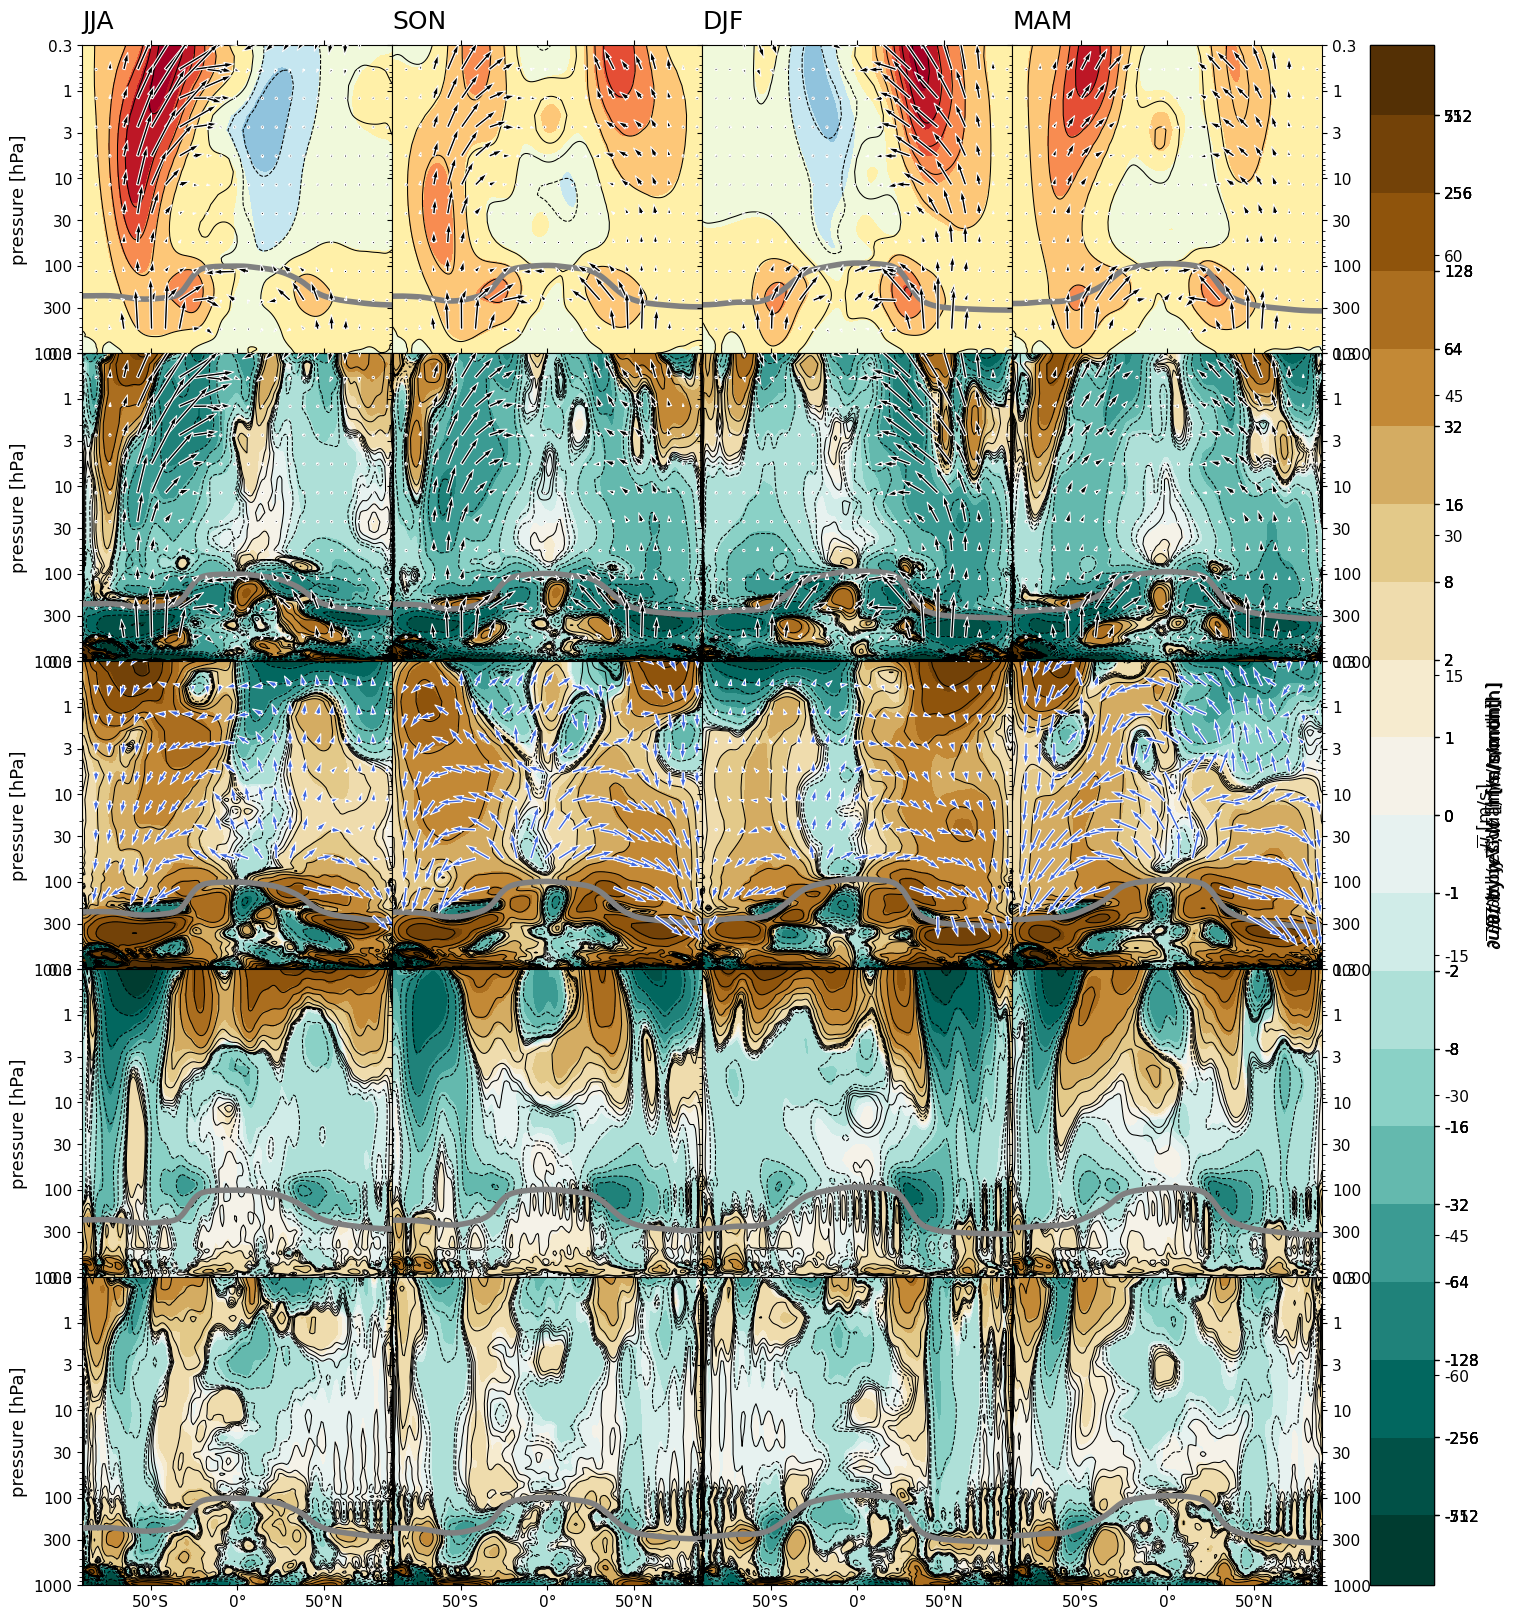

In [4]:
dvars = ['U', 'utendepfd', 'utendresvel', 'utendgw', 'utenddiff']
make_plot(dvars, epvscale=1.5e15, rvvscale=40, dslat=8, dsp=6, wspace=0, hspace=0)